# Régression Ridge, Lasso et nouvel estimateur

Ce notebook présente la régression Ridge, Lasso, et l'API de scikit-learn. Il explique plus en détail pourquoi la régression Lasso contraint les coefficients de la régression à s'annuler.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Un jeu de données pour un problème de régression

In [3]:
from sklearn.datasets import load_boston
data = load_boston()
X, y = data.data, data.target

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

On apprend la première régression linéaire.

In [5]:
from sklearn.linear_model import LinearRegression
lin = LinearRegression()
lin.fit(X_train, y_train)
lin.coef_

array([-1.13205698e-01,  4.07774544e-02, -3.45089298e-03,  3.20617502e+00,
       -1.36532265e+01,  4.50004571e+00, -8.49372877e-03, -1.30815349e+00,
        2.91962099e-01, -1.28261282e-02, -8.74096357e-01,  9.76382670e-03,
       -4.48963490e-01])

In [6]:
from sklearn.metrics import r2_score
r2_score(y_test, lin.predict(X_test))

0.6595254960413792

## Régression Ridge

La régression [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) optimise le problème qui suit :

$$\min_\beta E(\alpha, \beta) = \sum_{i=1}^n (y_i - X_i\beta)^2 + \alpha \lVert \beta \rVert ^2$$

C'est une régression linéaire avec une contrainte quadratique sur les coefficients. C'est utile lorsque les variables sont très corrélées, ce qui fausse souvent la résolution numérique. La solution peut s'exprimer de façon exacte.

$$\beta^* = (X'X + \alpha I)^{-1} X' Y$$

On voit qu'il est possible de choisir un $\alpha$ pour lequel la matrice $X'X + \alpha I$ est inversible. C'est aussi utile lorsqu'il y a beaucoup de variables car la probabilité d'avoir des variables corrélées est grande. Il est possible de choisir un $\alpha$ suffisamment grand pour que la matrice $ (X'X + \alpha I)^{-1}$ soit inversible et la solution unique.

In [7]:
from sklearn.linear_model import Ridge
rid = Ridge(10).fit(X_train, y_train)
r2_score(y_test, rid.predict(X_test))

0.6487191737684547

In [8]:
(r2_score(y_train, lin.predict(X_train)), 
 r2_score(y_train, rid.predict(X_train)))

(0.7680738152502515, 0.7611256054291524)

La contrainte introduite sur les coefficients augmente l'erreur sur la base d'apprentissage mais réduit la norme des coefficients.

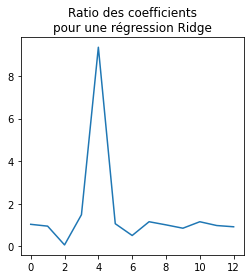

In [9]:
import numpy
import matplotlib.pyplot as plt
r = numpy.abs(lin.coef_) / numpy.abs(rid.coef_)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(r)
ax.set_title("Ratio des coefficients\npour une régression Ridge");

Un des coefficients est 10 fois plus grand et la norme des coefficients est plus petite.

In [10]:
numpy.linalg.norm(lin.coef_), numpy.linalg.norm(rid.coef_)

(14.822871038847616, 5.201434592576699)

De fait, il est préféreable de normaliser les variables avant d'appliquer la contrainte.

In [11]:
rid = Ridge(0.2, normalize=True).fit(X_train, y_train)
r2_score(y_test, rid.predict(X_test))

0.6244130847444307

In [12]:
numpy.linalg.norm(lin.coef_), numpy.linalg.norm(rid.coef_)

(14.822871038847616, 8.497194611236417)

## Régression Lasso

La régression [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) optimise le problème qui suit :

$$\min_\beta E(\alpha, \beta) = \sum_{i=1}^n (y_i - X_i\beta)^2 + \alpha \lVert \beta \rVert$$

C'est une régression linéaire avec une contrainte linéaire sur les coefficients. C'est utile lorsque les variables sont très corrélées, ce qui fausse souvent la résolution numérique. La solution ne s'exprime de façon exacte et la résolution utilise une méthode à base de gradient.

In [13]:
from sklearn.linear_model import Lasso
las = Lasso(5.).fit(X_train, y_train)
las.coef_

array([-0.        ,  0.02662449, -0.        ,  0.        ,  0.        ,
        0.        ,  0.02592687, -0.        ,  0.        , -0.00910167,
       -0.        ,  0.00496993, -0.72795831])

On voit que beaucoup de coefficients sont nuls.

In [14]:
las.coef_ == 0

array([ True, False,  True,  True,  True,  True, False,  True,  True,
       False,  True, False, False])

In [15]:
sum(las.coef_ == 0)

8

Comme pour la régression Ridge, il est préférable de normaliser. On étudie également le nombre de coefficients nuls en fonction de la valeur $\alpha$.

In [16]:
from tqdm import tqdm
res = []
for alf in tqdm([0.00001, 0.0001, 0.005, 0.01, 0.015, 
                 0.02, 0.025, 0.03, 0.04, 0.05, 0.06,
                 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4]):
    las = Lasso(alf, normalize=True).fit(X_train, y_train)
    r2 = r2_score(y_test, las.predict(X_test))
    res.append({'lambda': alf, 'r2': r2, 
                'nbnull': sum(las.coef_ == 0)})

    
from pandas import DataFrame
df = DataFrame(res)
df.head(5)

100%|██████████| 18/18 [00:00<00:00, 694.13it/s]


,lambda,r2,nbnull
0,0.00001,0.659517,0
1,0.00010,0.659439,0
2,0.00500,0.646681,1
3,0.01000,0.626564,3
4,0.01500,0.615930,4


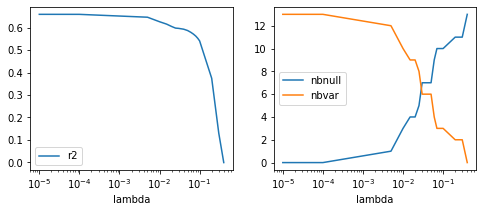

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].plot(df['lambda'], df['r2'], label='r2')
ax[1].plot(df['lambda'], df['nbnull'], label="nbnull")
ax[1].plot(df['lambda'], las.coef_.shape[0] - df['nbnull'], label="nbvar")
ax[0].set_xscale('log'); ax[1].set_xscale('log')
ax[0].set_xlabel("lambda"); ax[1].set_xlabel("lambda")
ax[0].legend(); ax[1].legend();

La régression Lasso annule les coefficients, voire tous les coefficients si le paramètre $\alpha$ est assez grand. Voyons cela pour une régression avec une seule variable. On doit minimiser l'expression :

$$E(\beta) = \sum_{i=1}^n (y_i - \beta x_i)^2 + \alpha |\beta|$$

Trouver $\beta^*$ qui minimise l'expression nécessite de trouver le paramètre $\beta$ tel que $E(\beta)=0$. On calcule la dérivée $E'(\beta)$ :

$$E'(\beta) = \left \{ \begin{array}{ll} \sum_{i=1}^n -x_i(y_i - \beta x_i) + \alpha & \text{si } \beta > 0 \\ \sum_{i=1}^n -x_i(y_i - \beta x_i) - \alpha & \text{si } \beta < 0 \end{array} \right .$$

Et :

$$E'(\beta) = 0 \Leftrightarrow \left \{ \begin{array}{ll} \beta = \frac{-\alpha + \sum_{i=1}^n x_i y_i}{\sum_{i=1}^n{x_i^2}} & \text{si } \beta > 0 \\ \beta = \frac{\alpha + \sum_{i=1}^n x_i y_i}{\sum_{i=1}^n{x_i^2}}  & \text{si } \beta < 0 \end{array} \right .$$

On voit que pour une grande valeur de $\alpha > \sum_i x_i y_i$, le paramètre $\beta$ n'a pas de solution. Dans le premier cas, la valeur est nécessairement négative alors que la solution ne fonctionne que si $\beta$ est positive. C'est la même situation contradictoire dans l'autre cas. La seule option possible lorsque $\alpha$ est très grand, c'est $\beta = 0$. On montre donc que ce qu'on a observé ci-dessus est vrai pour une régression à une dimension.

## Application à la sélection d'arbre d'une forêt aléatoire

Une forêt aléatoire est simplement une moyenne des prédictions d'arbres de régression.

$$RF(X) = \sum_{i=1}^p T_i(X)$$

Pourquoi ne pas utiliser une régression Lasso pour réduire le nombre d'arbres et exprimer la forêt aléatoire avec des coefficients $\beta$ estimés à l'aide d'une régression Lasso et choisis de telle sorte que beaucoup soient nuls.

$$RF(X) = \sum_{i=1}^p \beta_i T_i(X)$$

In [18]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(100).fit(X_train, y_train)

La prédiction d'un arbre s'obtient avec :

In [19]:
rf.estimators_[0].predict(X_test)

array([46. , 24.8, 10.4, 23. , 18.9, 19.6, 50. , 37.9, 25.1,  9.6, 16.7,
       27.1, 17.2, 17.8, 32.4, 25.2, 22. , 13.1, 20.3, 20.1, 11.3, 19.3,
       32.7, 29.8, 23.9, 19.3, 30.8, 17.8, 20.8, 17.1, 24.7, 18.8, 14.5,
       18.7, 21.7, 32.4, 14. , 50. , 13.1, 36.4, 18.2, 18.7, 22. , 20.1,
       50. , 17.5, 24.5, 25. , 32.4, 25.2, 14.5, 29.9, 50. , 19.1, 28.7,
       20.9, 16.1, 18.7, 19.6, 20.6, 10.2, 25. , 25. , 20.4, 18.9, 32.9,
       23.2, 24.7, 32.7, 17.3,  8.3, 24.5, 14.3, 18.2, 17.5,  8.3, 29.1,
       22.5, 22.9, 10.5, 18.7, 18.2, 17.5, 28. , 18.6, 14. , 23.1, 19.3,
       18.7, 10.2, 19.3, 18.3, 21.5, 17.4, 17.4, 19.6, 14.6, 13.1, 15.4,
       22. , 23.1, 22.8, 32.2,  7.5, 17.8, 19.6, 19.6, 19.4, 10.2, 17.2,
       26.6,  7. , 19.6, 22.9, 28.4, 19.5, 17.8, 14.3, 18. , 42.3, 44.8,
       15.6, 18. , 14.5, 32.9, 13.4, 14.5])

On construit une fonction qui concatène les prédictions des arbres.

In [20]:
def concatenate_prediction(X):
    preds = []
    for i in range(len(rf.estimators_)):
        pred = rf.estimators_[i].predict(X)
        preds.append(pred)
    return numpy.vstack(preds).T

concatenate_prediction(X_test).shape

(127, 100)

Et on observe la performance en fonction du paramètre $\alpha$ de la régression Lasso.

In [21]:
X_train_rf = concatenate_prediction(X_train)
X_test_rf = concatenate_prediction(X_test)

res = []
for alf in tqdm([0.0001, 0.01, 0.1, 0.2, 0.5, 1., 
                 1.2, 1.5, 2., 4., 6., 8., 10., 12.,
                 14, 16, 18, 20]):
    las = Lasso(alf, max_iter=40000).fit(X_train_rf, y_train)
    r2 = r2_score(y_test, las.predict(X_test_rf))
    r2_rf = r2_score(y_test, rf.predict(X_test))
    res.append({'lambda': alf, 'r2': r2, 'r2_rf': r2_rf,
                'nbnull': sum(las.coef_ == 0)})

  0%|          | 0/18 [00:00<?, ?it/s]C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.818118268059578, tolerance: 3.0799390765171504
  model = cd_fast.enet_coordinate_descent(
100%|██████████| 18/18 [00:04<00:00,  4.12it/s]


In [22]:
df = DataFrame(res)
df.head(3)

,lambda,r2,r2_rf,nbnull
0,0.0001,0.775410,0.786321,0
1,0.0100,0.777770,0.786321,8
2,0.1000,0.792718,0.786321,47


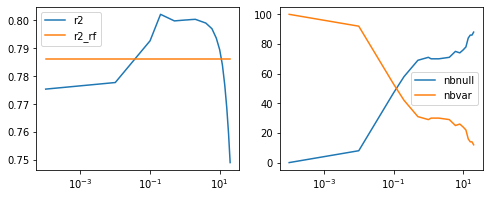

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].plot(df['lambda'], df['r2'], label='r2')
ax[0].plot(df['lambda'], df['r2_rf'], label='r2_rf')
ax[1].plot(df['lambda'], df['nbnull'], label="nbnull")
ax[1].plot(df['lambda'], las.coef_.shape[0] - df['nbnull'], label="nbvar")
ax[0].set_xscale('log'); ax[1].set_xscale('log')
ax[0].legend(); ax[1].legend();

## Explication géométrique de la nullité des coefficients dans une régression Lasso

On se place dans le cas d'un modèle très simple : $y = \alpha_1 x_1 + \alpha_2 x_2 + \epsilon$. Les coefficients optimaux sont obtenus en minimisant l'erreur $\sum (y - (a_1 x_1 + a_2 x_2))^2 + \lambda (|a_1| + |a_2|)$. On note $E(a_1, a_2) = E_r(a_1, a_2) + E_l(a_1, a_2)$. $E_r$ est l'erreur de régression, $E_l$ est l'erreur de Lasso. Les coefficients optimaux pour l'erreur $E_r$ sont $(a^*_1, a^*_2) = (\alpha_1 x_1 + \alpha_2)$. On représente maintenant sur un graphe les courbes de niveaux de ces deux erreurs. 

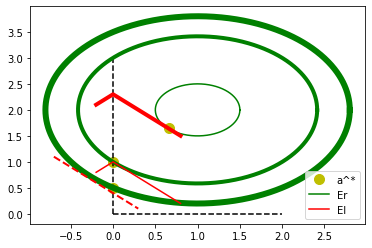

In [24]:
import math
def xyl1(t): return t, numpy.minimum(1 - t, t + 1)
def xyl2(t): return t, numpy.minimum(2.3 - t, t + 2.3)
def xyl3(t): return t, 0.4 - t
t = numpy.arange(1000) * 2 * math.pi / 1000
t2 = numpy.arange(500) / 500 - 0.2
fig, ax = plt.subplots(1, 1)
#ax.text(0.35, 2.7, "lambda1")
#ax.text(0.05, 2.5, "lambda2")
ax.plot([0.66], [1.66], "yo", label="a^*", ms=10)
ax.plot([0.0], [1.], "yo", ms=10)
ax.plot([0.0], [0.5], "yo", ms=10)
#ax.plot([0.0], [2.5], "yo")
ax.plot([0, 0], [0, 3], 'k--')
ax.plot([0, 2], [0, 0], 'k--')
ax.plot(numpy.cos(t) * 0.5 + 1, numpy.sin(t) * 0.5 + 2, "g", label="Er")
ax.plot(numpy.cos(t) * 2 ** 0.5 + 1, numpy.sin(t) * 2 ** 0.5 + 2, "g", lw=4)
ax.plot(numpy.cos(t) * 1.8 + 1, numpy.sin(t) * 1.8 + 2, "g", lw=6)
x, y = xyl1(t2); ax.plot(x, y, "r", label="El")
x, y = xyl2(t2); ax.plot(x, y, "r", lw=4)
x, y = xyl3(t2-0.5); ax.plot(x, y, "r--", lw=2)
ax.legend();

$E_r$ reste constante sur un cercle. $E_l$ reste constante sur une droite. Le point optimal solution de la régression Ridge est sur la tangente entre le cercle et la droite. Lorsqu'on augmente $\lambda$, il faut réduire l'erreur, donc passer sur une courbe de niveaux plus grande pour l'erreur $E_r$. Il arrive un moment où ce point tangent est situé sur un des axes. Ensuite, ce point tangent est situé de l'autre côté de l'axe et en annulant le coefficient $a_1$, on décroît à la fois $E_r$ et $E_l$. Vérifions numériquement sur une exemple en estimant les coefficients d'une régression Lasso en deux dimensions $y = a_1 X_1 + a_2 X_2 + \epsilon$ et en faisant varier la paramètre $\lambda$ de la contrainte.

100%|██████████| 61/61 [00:00<00:00, 1329.67it/s]


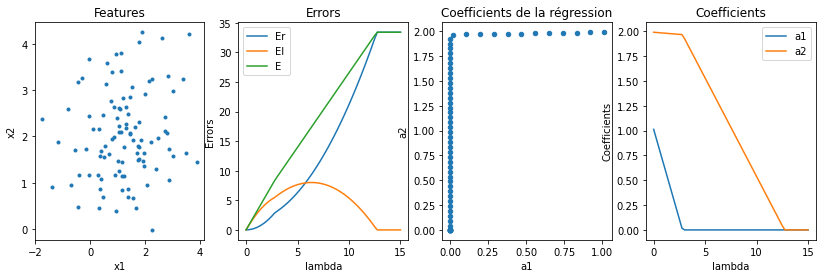

In [25]:
import warnings
from sklearn.metrics import mean_squared_error
import pandas

X = numpy.random.randn(100, 2) + 1.
X[:, 1] += 1.
y = numpy.sum(X, axis=1) + X[:, 1] + numpy.random.randn(100) / 10

def train_lasso(X, y, c):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        lasso = Lasso(c, fit_intercept=False)
        lasso.fit(X, y)
    Er = mean_squared_error(y, lasso.predict(X))
    El = numpy.abs(lasso.coef_).sum() * c
    return Er, El, lasso.coef_

obs = []
for i in tqdm(range(0, 61)):
    c = i / 4.
    Er, El, coef = train_lasso(X, y, c)
    obs.append(dict(c=c, Er=Er, El=El, E=Er+El, a1=coef[0], a2=coef[1]))
df = pandas.DataFrame(obs).set_index('c')

fig, ax = plt.subplots(1, 4, figsize=(14, 4))
ax[0].plot(X[:, 0], X[:, 1], '.', label='X')
ax[0].set_title("Features"); ax[0].set_xlabel("x1"); ax[0].set_ylabel("x2")
df[["Er", "El", "E"]].plot(ax=ax[1])
ax[1].set_title("Errors"); ax[1].set_xlabel("lambda"); ax[1].set_ylabel("Errors")
df.plot.scatter(x="a1", y="a2", ax=ax[2])
ax[2].set_title("Coefficients de la régression")
ax[2].set_xlabel("a1"); ax[2].set_ylabel("a2"); df[["a1", "a2"]].plot(ax=ax[3])
ax[3].set_title("Coefficients"); ax[3].set_xlabel("lambda"); ax[3].set_ylabel("Coefficients");

On retrouve numériquement le résultat énoncé ci-dessus.

## Validation croisée et API scikit-learn

La validation croisée est simple à faire dans *scikit-learn* est simple à faire si le modèle suit l'API de *scikit-learn* mais ce n'est pas le cas avec notre nouveau modèle. C'est pourtant essentiel pour s'assurer que le modèle est robuste. Toutefois *scikit-learn* permet de créer de nouveau modèle à la sauce *sciki-learn*.

In [26]:
from sklearn.base import BaseEstimator, RegressorMixin

class LassoRandomForestRegressor(BaseEstimator, RegressorMixin):
    def __init__(self,
                 # Lasso
                 alpha=1.0, fit_intercept=True, normalize=False,
                 precompute=False, copy_X=True, max_iter=1000,
                 tol=1e-4, warm_start_lasso=False, positive=False,
                 random_state=None, selection='cyclic',
                 # RF 
                 n_estimators=100,
                 criterion="mse",
                 max_depth=None,
                 min_samples_split=2,
                 min_samples_leaf=1,
                 min_weight_fraction_leaf=0.,
                 max_features="auto",
                 max_leaf_nodes=None,
                 min_impurity_decrease=0.,
                 min_impurity_split=None,
                 bootstrap=True,
                 oob_score=False,
                 n_jobs=None,
                 # random_state=None,
                 verbose=0,
                 warm_start_rf=False,
                 ccp_alpha=0.0,
                 max_samples=None):

        # Lasso
        self.alpha = alpha
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.precompute = precompute
        self.copy_X = copy_X
        self.max_iter = max_iter
        self.tol = tol
        self.warm_start_lasso = warm_start_lasso
        self.positive = positive
        self.random_state = random_state
        self.selection = selection
        # RF 
        self.n_estimators = n_estimators
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.min_weight_fraction_leaf = min_weight_fraction_leaf
        self.max_features = max_features
        self.max_leaf_nodes = max_leaf_nodes
        self.min_impurity_decrease = min_impurity_decrease
        self.min_impurity_split = min_impurity_split
        self.bootstrap = bootstrap
        self.oob_score = oob_score
        self.n_jobs = n_jobs
        self.random_state = random_state
        self.verbose = verbose
        self.warm_start_rf = warm_start_rf
        self.ccp_alpha = ccp_alpha
        self.max_samples = max_samples

    def _concatenate_prediction(self, X):
        preds = []
        for i in range(len(self.rf_.estimators_)):
            pred = self.rf_.estimators_[i].predict(X)
            preds.append(pred)
        return numpy.vstack(preds).T        
        
    def fit(self, X, y, sample_weight=None):
        self.rf_ = RandomForestRegressor(
            n_estimators=self.n_estimators, criterion=self.criterion,
            max_depth=self.max_depth, min_samples_split=self.min_samples_split,
            min_samples_leaf=self.min_samples_leaf,
            min_weight_fraction_leaf=self.min_weight_fraction_leaf,
            max_features=self.max_features, max_leaf_nodes=self.max_leaf_nodes,
            min_impurity_decrease=self.min_impurity_decrease,
            min_impurity_split=self.min_impurity_split, bootstrap=self.bootstrap,
            oob_score=self.oob_score, n_jobs=self.n_jobs,
            random_state=self.random_state, verbose=self.verbose,
            warm_start=self.warm_start_rf, ccp_alpha=self.ccp_alpha,
            max_samples=self.max_samples)
        
        self.rf_.fit(X, y, sample_weight=sample_weight)
        X_rf = self._concatenate_prediction(X)
        
        self.lasso_ = Lasso(
            alpha=self.alpha, max_iter=self.max_iter, fit_intercept=self.fit_intercept,
            normalize=self.normalize, precompute=self.precompute, copy_X=self.copy_X,
            tol=self.tol, warm_start=self.warm_start_lasso, positive=self.positive,
            random_state=self.random_state, selection=self.selection)
        
        self.lasso_.fit(X_rf, y)
        return self
    
    def predict(self, X):
        X_rf = self._concatenate_prediction(X)
        return self.lasso_.predict(X_rf)


model = LassoRandomForestRegressor(
            alpha=1, n_estimators=100, max_iter=10000)
model.fit(X_train, y_train)
pred = model.predict(X_test)
r2_score(y_test, pred)

0.8869318967308191

Et la validation croisée  fut :

In [27]:
from sklearn.model_selection import cross_val_score
cross_val_score(model, X_train, y_train, cv=5)

array([0.92772002, 0.90218937, 0.84563603, 0.88047392, 0.73041268])

Ce n'est pas très robuste. Peut-être est-ce dû à l'ordre des données (un léger effet temporel).

In [28]:
from sklearn.model_selection import ShuffleSplit
cross_val_score(LassoRandomForestRegressor(
                    n_estimators=100, alpha=10, max_iter=10000),
                X_train, y_train, cv=ShuffleSplit(5))

array([0.9226095 , 0.91741457, 0.88203925, 0.77380077, 0.89373783])

Pas beaucoup mieux. Le modèle n'est pas très robuste.

On essaye néanmoins de trouver les meilleurs paramètres à l'aide d'une grille de recherche.

In [29]:
from sklearn.model_selection import GridSearchCV
params = {'alpha': [0.1, 0.5, 1., 2., 5., 10],
          'n_estimators': [10, 20, 50, 100],
          'max_iter': [10000]
         }
grid = GridSearchCV(LassoRandomForestRegressor(),
                    param_grid=params, verbose=1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(estimator=LassoRandomForestRegressor(),
             param_grid={'alpha': [0.1, 0.5, 1.0, 2.0, 5.0, 10],
                         'max_iter': [10000],
                         'n_estimators': [10, 20, 50, 100]},
             verbose=1)

In [30]:
grid.best_params_

{'alpha': 1.0, 'max_iter': 10000, 'n_estimators': 100}

In [31]:
r2_score(y_test, grid.best_estimator_.predict(X_test))

0.8945178461701823

In [32]:
sum(grid.best_estimator_.lasso_.coef_ == 0)

67

On a réussi à supprimer 27 arbres.

## Optimisation mémoire

Le modèle précédent n'est pas optimal dans le sens où il stocke en mémoire tous les arbres, mêmes ceux associés à un coefficient nuls après la régression Lasso alors que le calcul ne sert à rien puisque ignoré.

In [33]:
class OptimizedLassoRandomForestRegressor(BaseEstimator, RegressorMixin):
    def __init__(self,
                 # Lasso
                 alpha=1.0, fit_intercept=True, normalize=False,
                 precompute=False, copy_X=True, max_iter=1000,
                 tol=1e-4, warm_start_lasso=False, positive=False,
                 random_state=None, selection='cyclic',
                 # RF 
                 n_estimators=100,
                 criterion="mse",
                 max_depth=None,
                 min_samples_split=2,
                 min_samples_leaf=1,
                 min_weight_fraction_leaf=0.,
                 max_features="auto",
                 max_leaf_nodes=None,
                 min_impurity_decrease=0.,
                 min_impurity_split=None,
                 bootstrap=True,
                 oob_score=False,
                 n_jobs=None,
                 # random_state=None,
                 verbose=0,
                 warm_start_rf=False,
                 ccp_alpha=0.0,
                 max_samples=None):
        
        # Lasso
        self.alpha = alpha
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.precompute = precompute
        self.copy_X = copy_X
        self.max_iter = max_iter
        self.tol = tol
        self.warm_start_lasso = warm_start_lasso
        self.positive = positive
        self.random_state = random_state
        self.selection = selection
        # RF 
        self.n_estimators = n_estimators
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.min_weight_fraction_leaf = min_weight_fraction_leaf
        self.max_features = max_features
        self.max_leaf_nodes = max_leaf_nodes
        self.min_impurity_decrease = min_impurity_decrease
        self.min_impurity_split = min_impurity_split
        self.bootstrap = bootstrap
        self.oob_score = oob_score
        self.n_jobs = n_jobs
        self.random_state = random_state
        self.verbose = verbose
        self.warm_start_rf = warm_start_rf
        self.ccp_alpha = ccp_alpha
        self.max_samples = max_samples

    def _concatenate_prediction(self, X):
        preds = []
        for i in range(len(self.rf_.estimators_)):
            pred = self.rf_.estimators_[i].predict(X)
            preds.append(pred)
        return numpy.vstack(preds).T        
        
    def fit(self, X, y, sample_weight=None):
        
        self.rf_ = RandomForestRegressor(
            n_estimators=self.n_estimators, criterion=self.criterion,
            max_depth=self.max_depth, min_samples_split=self.min_samples_split,
            min_samples_leaf=self.min_samples_leaf,
            min_weight_fraction_leaf=self.min_weight_fraction_leaf,
            max_features=self.max_features, max_leaf_nodes=self.max_leaf_nodes,
            min_impurity_decrease=self.min_impurity_decrease,
            min_impurity_split=self.min_impurity_split, bootstrap=self.bootstrap,
            oob_score=self.oob_score, n_jobs=self.n_jobs,
            random_state=self.random_state, verbose=self.verbose,
            warm_start=self.warm_start_rf, ccp_alpha=self.ccp_alpha,
            max_samples=self.max_samples)
        
        self.rf_.fit(X, y, sample_weight=sample_weight)
        X_rf = self._concatenate_prediction(X)
        
        self.lasso_ = Lasso(
            alpha=self.alpha, max_iter=self.max_iter, fit_intercept=self.fit_intercept,
            normalize=self.normalize, precompute=self.precompute, copy_X=self.copy_X,
            tol=self.tol, warm_start=self.warm_start_lasso, positive=self.positive,
            random_state=self.random_state, selection=self.selection)
        
        self.lasso_.fit(X_rf, y)
        
        # on ne garde que les arbres associées à des coefficients non nuls
        self.coef_ = []
        self.intercept_ = self.lasso_.intercept_
        self.estimators_ = []
        for i in range(len(self.rf_.estimators_)):
            if self.lasso_.coef_[i] != 0:
                self.estimators_.append(self.rf_.estimators_[i])
                self.coef_.append(self.lasso_.coef_[i])
        
        self.coef_ = numpy.array(self.coef_)
        del self.lasso_
        del self.rf_        
        return self
    
    def predict(self, X):
        preds = []
        for i in range(len(self.estimators_)):
            pred = self.estimators_[i].predict(X)
            preds.append(pred)
        x_rf = numpy.vstack(preds).T 
    
        return x_rf @ self.coef_ + self.intercept_

model2 = OptimizedLassoRandomForestRegressor()
model2.fit(X_train, y_train)
pred = model2.predict(X_test)
r2_score(y_test, pred)

C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.43406359249849, tolerance: 3.248936158311346
  model = cd_fast.enet_coordinate_descent(


0.8942144703733796

Le modèle produit bien les mêmes résultats. Vérifions que le nouveau modèle prend moins de place une fois enregistré sur le disque.

In [34]:
import pickle

with open("optimzed_rf.pickle", "wb") as f:
    pickle.dump(model2, f)

In [35]:
with open("optimzed_rf.pickle", "rb") as f:
    model2 = pickle.load(f)

r2_score(y_test, model2.predict(X_test))

0.8942144703733796

In [36]:
with open("lasso_rf.pickle", "wb") as f:
    pickle.dump(model, f)

In [37]:
import os
os.stat("optimzed_rf.pickle").st_size, os.stat("lasso_rf.pickle").st_size

(1038603, 2938512)

C'est bien le cas.